<a href="https://colab.research.google.com/github/ElenaGordienko1/NLP/blob/main/NLP4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Выпонение лабораторной работы 4

Импорт библиотек ⭐

In [2]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

### Загрузка и предобработка

In [4]:
russian_stopwords = set("""
и в во не что он на я с со как а то все она так его но да ты к у же вы за бы по только ее мне было вот от меня еще нет о из ему теперь когда даже ну вдруг ли если уже или ни быть был него до вас нибудь опять уж вам ведь там потом себя ничего ей может они тут где есть надо ней для мы тебя их чем была сам чтоб без будто чего раз тоже себе под будет ж тогда кто этот того потому этого какие совсем ними здесь этом один почти мой тем чтобы нее как раз уж еще бы нее там них
""".split())

df = pd.read_csv("/content/final_review_dataset_extended.csv")
df = df[['review', 'rating_value']].dropna()
df = df[df['review'].str.strip().astype(bool)]

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^а-яёa-z\s]", " ", text, flags=re.IGNORECASE)
    text = re.sub(r"\s+", " ", text).strip()
    words = text.split()
    words = [w for w in words if w not in russian_stopwords and len(w) > 2]
    return " ".join(words)

df['clean_text'] = df['review'].apply(preprocess_text)
df.head()


,review,rating_value,clean_text
0,Добрый день! Я являюсь ИП и стоял перед выборо...,5,добрый день являюсь стоял перед выбором банка ...
1,Здравствуйте! Достаточно давно являюсь клиенто...,5,здравствуйте достаточно давно являюсь клиентом...
2,"Здравствуйте,являюсь клиентом банка с ноября 2...",5,здравствуйте являюсь клиентом банка ноября год...
3,14 января 2023 года была попытка перевода дене...,1,января года попытка перевода денег размере тыс...
4,"У меня сложилось устойчивое впечатление, что в...",1,сложилось устойчивое впечатление банке работаю...


### Векторизация TF-IDF

In [5]:
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['clean_text'])

###  Кластеризация K-Means

In [6]:
kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(X)
df['cluster'] = labels

### Анализ датасета

Распределение по категориям:

rating_value
1    5749
2     775
3     397
4     584
5    4887
Name: count, dtype: int64


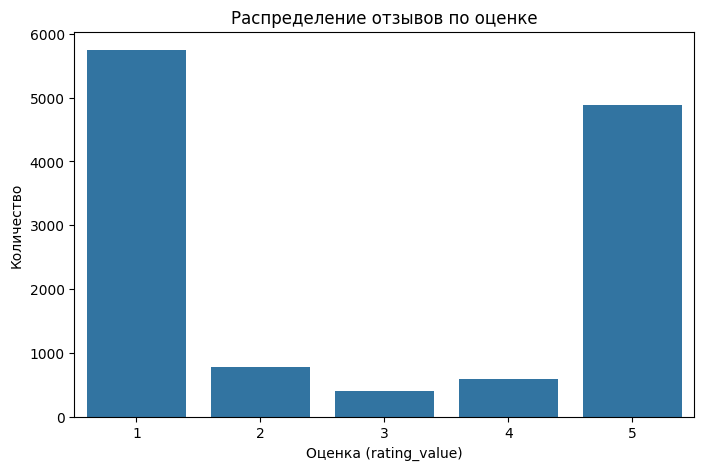

In [7]:
rating_counts = df['rating_value'].value_counts().sort_index()
print("Распределение по категориям:\n")
print(rating_counts)

plt.figure(figsize=(8, 5))
sns.barplot(x=rating_counts.index.astype(str), y=rating_counts.values)
plt.title("Распределение отзывов по оценке")
plt.xlabel("Оценка (rating_value)")
plt.ylabel("Количество")
plt.show()


Больше всего отзывов с оценками "5" и "1", что может плохо сказаться на обучении

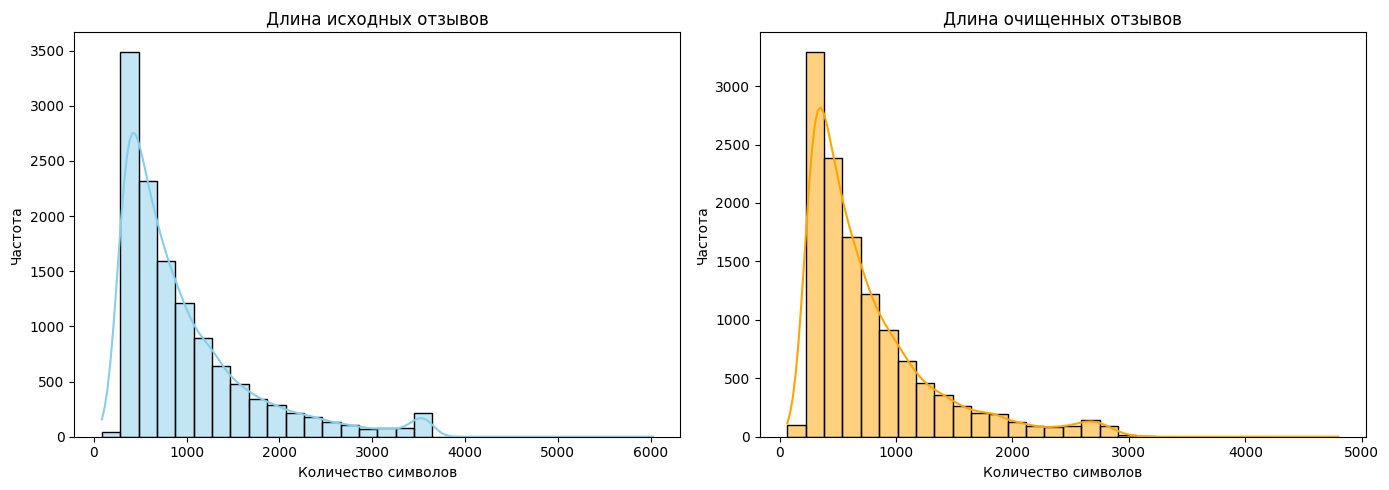

In [11]:
df['text_len_raw'] = df['review'].apply(len)
df['text_len_processed'] = df['clean_text'].apply(len)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['text_len_raw'], bins=30, kde=True, color='skyblue')
plt.title("Длина исходных отзывов")
plt.xlabel("Количество символов")
plt.ylabel("Частота")

plt.subplot(1, 2, 2)
sns.histplot(df['text_len_processed'], bins=30, kde=True, color='orange')
plt.title("Длина очищенных отзывов")
plt.xlabel("Количество символов")
plt.ylabel("Частота")

plt.tight_layout()
plt.show()


Длина практически не изменилась после обработки, мало мусора удалилось

In [9]:
for label in sorted(df['cluster'].unique()):
    print(f"\nКластер {label}:")
    for text in df[df['cluster'] == label]['review'].head(3):
        print(f"- {text}")



Кластер 0:
- Добрый день! Я являюсь ИП и стоял перед выбором банка для открытия расчетного счета. Посоветовали обратиться в Россельхозбанк, что я и сделал , и не прогадал. Теперь хочу рассказать о моем впечатлении , может быть это тоже поможет кому нибудь сделать выбор ! Офис расположен удобно, электронная очередь обеспечивает порядок и дисциплину. После взятия талона вызвали через 2 минуты к специалисту. Мне подробно рассказали про условия счета, про возможность проведения платежных поручений, про мобильное приложение. На все вопросы ответили, приложение подключили и рассказали, как им пользоваться. Всего минут 10 и мою потребность полностью удовлетворили. Сотрудник просто грамотно и на понятном нам клиентам языке рассказал все, открыто и без всяких подводных камней. Это приятно удивляет. Так же я рассказал, что планирую кредитоваться и узнал условия текущие по кредитам. С этим вопросом мне надо подумать, так что мы с сотрудником обменялись контактными данными для связи и назначения 

### Разбиение на train, test и val выборки

In [10]:
train_val, test = train_test_split(df, test_size=0.2, random_state=42)
train, val = train_test_split(train_val, test_size=0.25, random_state=42)

print(f"Train size: {len(train)}")
print(f"Validation size: {len(val)}")
print(f"Test size: {len(test)}")


Train size: 7434
Validation size: 2479
Test size: 2479
